##### $\hspace{15pt}$ **Filename: neuralNetworkOnSyntheticdData.ipynb**
##### $\hspace{1.5pt}$ **Date Created: December 4, 2023**
##### $\rule{10.5in}{1pt}$
##### **Fit a neural network to synthetic training data. Data is first generated from a specified univariate function. The synthetic data is split into training and test sets, which are then passed to a sequence of alternating forward and backward propagation.**

##### **The content of this notebook is motivated by the discussion in section 6.3 of the book [Deep Learning with Pytorch](https://www.manning.com/books/deep-learning-with-pytorch).**
##### $\rule{10.5in}{1pt}$

##### Load modules and packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch

##### Set the float format of pandas dataframes.

In [2]:
pd.options.display.float_format = "{:.2f}".format

##### Create data for demonstration. The value of the dependent variable $y$ is determined by the equation $y = f(x) + \epsilon $, where

##### $$f(x) = 18.75x - 5x^2 + 0.33x^3 \hspace{1in} \epsilon \sim N(0, 1)$$

$\hspace{1in}$

In [3]:
np.random.seed(1)
x = np.linspace(0, 10)
y = 18.75*x - 5*x**2 + 0.33*x**3 + np.random.normal(size = len(x))
data = pd.DataFrame({"x": x, "y": y})
data.head()

,x,y
0,0.00,1.62
1,0.20,3.01
2,0.41,6.31
3,0.61,8.61
4,0.82,13.02


##### Split the data into training and test sets.

In [4]:
nSamplesData = len(x)
nSamplesTest = int(0.3*nSamplesData)
indices = list(range(nSamplesData))
shuffledIndices = random.sample(indices, len(indices))
trainIndices = shuffledIndices[:-nSamplesTest]
testIndices = shuffledIndices[-nSamplesTest:]

xTrain = x[trainIndices]
yTrain = y[trainIndices]
xTest = x[testIndices]
yTest = y[testIndices]

##### Plot the training and test sets.

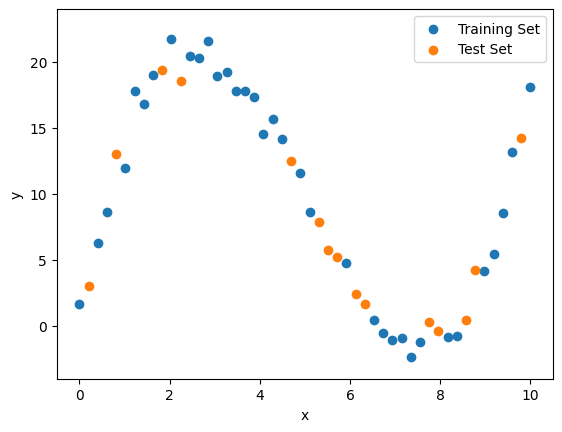

In [5]:
plt.scatter(xTrain, yTrain)
plt.scatter(xTest, yTest)
plt.ylim(-4, 24)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Training Set", "Test Set"], loc ="upper right")
plt.show()

##### Define a function that will be used to fit a neural network on training data and evaluate it on test data.

In [6]:
def estimateParams(nEpochs, optimizer, model, loss, xTrain, yTrain, xTest, yTest, displayEpochs = True):
    "Estimate the parameters using a sequence of forward and backward propagation."

    trainLossList = []
    testLossList = []
    for epoch in range(1, nEpochs + 1):

        yHatTrain = model(xTrain)
        trainL = loss(yHatTrain, yTrain)
        yHatTest = model(xTest)
        testL = loss(yHatTest, yTest)

        optimizer.zero_grad()
        trainL.backward()
        optimizer.step()
        params = list(model.parameters())

        if displayEpochs:

           if epoch <= 3 or epoch >= nEpochs - 2:

              print('Epoch %d:' % epoch)
              print('    Training Loss = %f' % trainL)
              print('        Test Loss = %f' % testL)
              print('')

           if epoch == 4:
              print('...\n...\n...\n')

        if not torch.isfinite(trainL).all():
           break

        trainLossList.append(float(trainL))
        testLossList.append(float(testL))

    return params, yHatTrain, trainLossList, yHatTest, testLossList

##### Run the function using a neural network with a single hidden layer of 10 neurons and with a sigmoid activation function.

In [7]:
nEpochs = 50000
model = torch.nn.Sequential(torch.nn.Linear(1, 10),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(10, 1))
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
loss = torch.nn.MSELoss()
xTensorTrain = torch.from_numpy(xTrain).unsqueeze(1).to(torch.float32)
yTensorTrain = torch.from_numpy(yTrain).unsqueeze(1).to(torch.float32)
xTensorTest = torch.from_numpy(xTest).unsqueeze(1).to(torch.float32)
yTensorTest = torch.from_numpy(yTest).unsqueeze(1).to(torch.float32)
estimatedParams, yHatTrain, trainLossList, yHatTest, testLossList = estimateParams(nEpochs = nEpochs, optimizer = optimizer, model = model, loss = loss,
                                                                                   xTrain = xTensorTrain, yTrain = yTensorTrain, xTest = xTensorTest,
                                                                                   yTest = yTensorTest)

Epoch 1:
    Training Loss = 163.161835
        Test Loss = 84.658882

Epoch 2:
    Training Loss = 147.302521
        Test Loss = 74.400200

Epoch 3:
    Training Loss = 133.662659
        Test Loss = 66.113068

...
...
...

Epoch 49998:
    Training Loss = 0.828169
        Test Loss = 2.013315

Epoch 49999:
    Training Loss = 0.847043
        Test Loss = 2.030641

Epoch 50000:
    Training Loss = 0.828134
        Test Loss = 2.013319



##### Display how the values of the loss function change in the first 4000 epochs in each of the training and test sets.

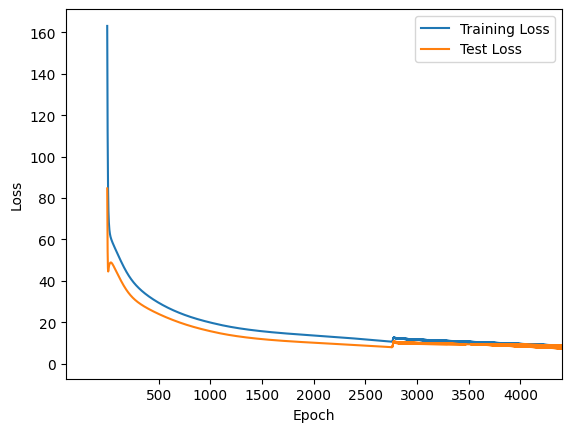

In [8]:
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.plot(range(1, len(trainLossList) + 1), trainLossList)
plt.plot(range(1, len(testLossList) + 1), testLossList)
plt.xticks(np.arange(500, 4500, step = 500))
plt.xlim([-400, 4400])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Test Loss"], loc ="upper right")
plt.show()

##### Store in a dataframe the estimated values of the dependent variable. Display a sample of 5 estimated values.

In [9]:
xConcatenated = np.concatenate((xTrain, xTest))
yHatConcatenated = np.concatenate((yHatTrain.squeeze(1).detach().numpy(), yHatTest.squeeze(1).detach().numpy()))

yHatDf = pd.DataFrame({'x': xConcatenated, 'yHat': yHatConcatenated})
yHatDf.sort_values(by = 'x', inplace = True)
yHatDf.reset_index(drop = True, inplace = True)
yHatDf.head()

,x,yHat
0,0.00,1.66
1,0.20,4.16
2,0.41,6.36
3,0.61,8.36
4,0.82,10.57


##### Plot the curve estimated by the fitted neural network  together with the data.

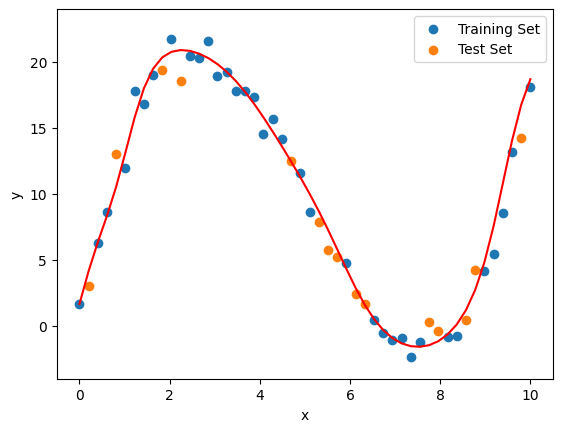

In [10]:
plt.scatter(xTrain, yTrain)
plt.scatter(xTest, yTest)
plt.plot(yHatDf.x, yHatDf.yHat, color = "r")
plt.ylim(-4, 24)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Training Set", "Test Set"], loc ="upper right")
plt.show()